In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
device = torch.device('cuda:5') if torch.cuda.is_available() else "cpu"
device

device(type='cuda', index=5)

## Engine

In [3]:
from torch.utils.tensorboard import SummaryWriter
import torchinfo
writer = SummaryWriter()

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [4]:
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float,float]:

    model.train()
    train_loss, train_acc = 0.0,0.0

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
    
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            # print(x.device)
            y_pred_logits = model(x)
            
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
            test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)
        
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc



    
# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    return results

## Dataset prep

In [5]:
from pathlib import Path

data_path = Path("/local/scratch/camelyon17/camelyon17_v1.0/patches")

In [6]:
import os
def walk_through_directory(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_directory(dir_path=data_path)

There are 50 directories and 0 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches'.
There are 0 directories and 2587 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_039_node_1'.
There are 0 directories and 10623 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_060_node_3'.
There are 0 directories and 1596 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_017_node_1'.
There are 0 directories and 5339 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_072_node_0'.
There are 0 directories and 5371 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_020_node_4'.
There are 0 directories and 1275 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_038_node_2'.
There are 0 directories and 5288 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_044_node_4'.


There are 0 directories and 3950 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_066_node_2'.
There are 0 directories and 7727 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_045_node_1'.
There are 0 directories and 3808 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_017_node_4'.
There are 0 directories and 13455 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_017_node_2'.
There are 0 directories and 3466 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_061_node_4'.
There are 0 directories and 14703 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_092_node_1'.
There are 0 directories and 7294 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_015_node_1'.
There are 0 directories and 6956 images in '/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_088_node_1'.
There are 0 directories and 57375 images in '/local/scratch/camelyon17/camelyo

Random image path: /local/scratch/camelyon17/camelyon17_v1.0/patches/patient_096_node_0/patch_patient_096_node_0_x_36128_y_5664.png
Image class: patient_096_node_0
Image height: 96
Image width: 96


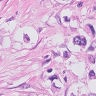

In [7]:
# Printing random image
import random
from PIL import Image

random.seed(42)

image_path_list = list(data_path.glob("*/*.png"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [8]:
# from torch.utils.data import DataLoader, Subset, Dataset
# from torchvision import datasets, transforms

# class DataFromDict(Dataset):
#     def __init__(self,input_dict ):
#         self.input_dict = input_dict
#         self.input_keys = list(input_dict.keys())

#     def __len__(self):
#         return len(self.input_keys)

#     def __getitem__(self,idx):
#         item = self.input_dict[self.img_keys[idx]]['item_key']
#         label = self.input_dict[self.img_keys[idx]]['label_key']
#         return item, label

In [9]:
# from torch.utils.data import DataLoader, Subset
# from torchvision import datasets, transforms
# import numpy as np
# import re

# image_path_list = list(data_path.glob("*/*.png"))
# total_samples=len(image_path_list)
# num_samples=20000
# indices = torch.tensor(np.random.permutation(np.arange(total_samples))[:num_samples])
# # print(total_samples)

# regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')

# transform=torchvision.transforms.ToTensor()

# print(transform(Image.open(image_path_list[0])).shape)

# image_dict={}

# for i in indices[:10]:
#     mo=regex.search(str(image_path_list[i])[69:])
#     # print(mo.groups())
#     patient,node,x,y = mo.groups()
#     patient,node,x,y = int(patient), int(node), int(x), int(y)
#     img = transform(np.asarray(Image.open(image_path_list[i]))[:,:,:3])
#     image_dict[str(image_path_list[i])] = 

    

# # print(len("/local/scratch/camelyon17/camelyon17_v1.0/patches/patient_086_node_0/"))


# complete_data = datasets.ImageFolder(
#     root = data_path,
#     transform=torchvision.transforms.ToTensor(),
# )
# complete_data.class_to_idx
# # -30,-5
# # patch_patient_088_node_1_x_20096_y_14592.png
# data = Subset(complete_data, indices)

# label_regex = re.compile(r'(\d\d\d)_node_(\d)')

# for i in range(5):
#     img, label = data[i][0], data[i][1]
#     mo=label_regex.search(complete_data.classes[label])
#     patient_number=int(mo.groups()[0])
#     node=int(mo.groups()[1])
#     print(img.shape, int(mo.groups()[0]), int(mo.groups()[1]))

In [10]:
#reading metadata.csv
import pandas as pd

df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")

df

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split
0,0,4,4,3328,21792,1,0,0,0
1,1,4,4,3200,22272,1,0,0,0
2,2,4,4,3168,22272,1,0,0,0
3,3,4,4,3328,21760,1,0,0,0
4,4,4,4,3232,22240,1,0,0,0
...,...,...,...,...,...,...,...,...,...
455949,455949,88,1,14784,7648,0,45,4,1
455950,455950,99,4,3872,11328,0,49,4,0
455951,455951,92,1,31968,9536,0,47,4,0
455952,455952,81,4,23712,12192,0,41,4,0


In [11]:
# Make function to find classes in target directory
from typing import Dict, List, Tuple
import pathlib
import re
import numpy as np

def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = ["Non-cancerous", "Cancerous"]
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)[32:64, 32:64, :]
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        mo=regex.search(str(image_path)[69:])
    # print(mo.groups())
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)

        has_cancer = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = "Cancerous" if has_cancer else "Non-cancerous" # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.ToTensor()
])

data = ImageFolderCustom(
    targ_dir = data_path,
    transform=data_transform
)
print(len(data))
print(data[0][0].shape, data[0][1])
print(data.classes)
print(data.class_to_idx)

455954
torch.Size([3, 32, 32]) 0
['Non-cancerous', 'Cancerous']
{'Non-cancerous': 0, 'Cancerous': 1}


In [13]:
# l = int(df[(df["patient"] == 39) & (df["node"] == 1) & (df["x_coord"] == 7872) & (df["y_coord"] == 30432)]["tumor"].iloc[0])
# print(l)
# img = Image.open(image_path_list[0])
# img_arr = np.asarray(img)[:,32:64, 32:64]
# print(img_arr.shape)


## TinyVGG

In [91]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data = ImageFolderCustom(
    targ_dir = data_path,
    transform=manual_transform
)
print(len(data))
print(data[0][0].shape, data[0][1])
print(data.classes)
print(data.class_to_idx)

455954
torch.Size([3, 32, 32]) 0
['Non-cancerous', 'Cancerous']
{'Non-cancerous': 0, 'Cancerous': 1}


In [98]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy


manual_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

BATCH_SIZE = 32
total_samples=len(data)
num_samples=100000


indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples))[:num_samples])

train_indices=indices[:int(0.8*num_samples)]
test_indices=indices[int(0.8*num_samples):]

train_dataset=Subset(data, train_indices)
test_dataset=Subset(data, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True
)
print(len(train_dataset), len(test_dataset))

80000 20000


In [99]:
IMAGE_SIZE = 32

class TinyVGG(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_channels,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels= hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units* (IMAGE_SIZE//4) * (IMAGE_SIZE//4),
                out_features = output_shape
            )
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [100]:
model0 = TinyVGG(input_channels=3, hidden_units=10, output_shape=2).to(device)
# torchinfo.summary(model0, (1,3,224,224))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [101]:
#example forward pass
img, label = next(iter(test_dataloader))
img = img[0].unsqueeze(dim=0).to(device)
label = label[0]
# 
print(img[0].shape)
y_pred_logits = model0(img)
print("Logits: ", y_pred_logits)
y_pred_prob = torch.softmax(y_pred_logits, dim=1)
print("Prob: ", y_pred_prob)
y_pred_label = torch.argmax(y_pred_prob, dim=1)
print("Predicted label: ", y_pred_label)
print("Real Label: ", label)

torch.Size([3, 32, 32])
Logits:  tensor([[0.0467, 0.0489]], device='cuda:2', grad_fn=<AddmmBackward0>)
Prob:  tensor([[0.4995, 0.5005]], device='cuda:2', grad_fn=<SoftmaxBackward0>)
Predicted label:  tensor([1], device='cuda:2')
Real Label:  tensor(1)


In [102]:
train(model0, train_dataloader, test_dataloader, optimizer, loss_fn, 10, device, None)

 10%|█         | 1/10 [01:55<17:22, 115.83s/it]

Epoch: 1 | train_loss: 0.6195 | train_acc: 0.6416 | test_loss: 0.5135 | test_acc: 0.7433


 20%|██        | 2/10 [03:35<14:11, 106.48s/it]

Epoch: 2 | train_loss: 0.5034 | train_acc: 0.7603 | test_loss: 0.4530 | test_acc: 0.7952


 30%|███       | 3/10 [05:18<12:13, 104.84s/it]

Epoch: 3 | train_loss: 0.4383 | train_acc: 0.8036 | test_loss: 0.3614 | test_acc: 0.8478


 40%|████      | 4/10 [07:01<10:25, 104.21s/it]

Epoch: 4 | train_loss: 0.3890 | train_acc: 0.8355 | test_loss: 0.3882 | test_acc: 0.8256


 50%|█████     | 5/10 [08:45<08:39, 103.89s/it]

Epoch: 5 | train_loss: 0.3623 | train_acc: 0.8498 | test_loss: 0.3370 | test_acc: 0.8640


 60%|██████    | 6/10 [10:27<06:53, 103.44s/it]

Epoch: 6 | train_loss: 0.3447 | train_acc: 0.8590 | test_loss: 0.3110 | test_acc: 0.8731


 70%|███████   | 7/10 [12:11<05:10, 103.47s/it]

Epoch: 7 | train_loss: 0.3309 | train_acc: 0.8659 | test_loss: 0.3304 | test_acc: 0.8713


 80%|████████  | 8/10 [13:54<03:26, 103.23s/it]

Epoch: 8 | train_loss: 0.3225 | train_acc: 0.8698 | test_loss: 0.2883 | test_acc: 0.8859


 90%|█████████ | 9/10 [15:39<01:43, 103.92s/it]

Epoch: 9 | train_loss: 0.3139 | train_acc: 0.8735 | test_loss: 0.3098 | test_acc: 0.8744


100%|██████████| 10/10 [17:23<00:00, 104.30s/it]

Epoch: 10 | train_loss: 0.3076 | train_acc: 0.8772 | test_loss: 0.2893 | test_acc: 0.8845


{'train_loss': [0.6194567772388458,
  0.5034450042784214,
  0.4383050509572029,
  0.38896895580291746,
  0.3622746847748756,
  0.3446577535867691,
  0.33089231877326963,
  0.3224909020721912,
  0.31389375881552695,
  0.30764368366003036],
 'train_acc': [0.641625,
  0.76035,
  0.803575,
  0.8355,
  0.8498,
  0.8589625,
  0.865875,
  0.86975,
  0.8735375,
  0.8772],
 'test_loss': [0.5135014057636261,
  0.45302165760993957,
  0.3613624082326889,
  0.3881845613718033,
  0.33700660697221757,
  0.31100391194820404,
  0.3304460021853447,
  0.28832855656147005,
  0.309759696829319,
  0.2893071149945259],
 'test_acc': [0.7433,
  0.79515,
  0.84775,
  0.82565,
  0.86405,
  0.8731,
  0.8713,
  0.8859,
  0.8744,
  0.88455]}

In [103]:
SAVE_PATH = Path("models/TinyVGG_100k.pt")
torch.save(obj=model0.state_dict(), f=SAVE_PATH)

## Efficient Net b0

In [65]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
torchinfo.summary(
    model=model,
    input_size=(64,3,224,224),
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Output Shape         Param #
EfficientNet (EfficientNet)                                  [64, 1000]           --
├─Sequential (features)                                      [64, 1280, 7, 7]     --
│    └─Conv2dNormActivation (0)                              [64, 32, 112, 112]   --
│    │    └─Conv2d (0)                                       [64, 32, 112, 112]   864
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   64
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   --
│    └─Sequential (1)                                        [64, 16, 112, 112]   --
│    │    └─MBConv (0)                                       [64, 16, 112, 112]   1,448
│    └─Sequential (2)                                        [64, 24, 56, 56]     --
│    │    └─MBConv (0)                                       [64, 24, 56, 56]     6,004
│    │    └─MBConv (1)                               

In [66]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy


auto_transform = weights.transforms()
data = ImageFolderCustom(
    targ_dir = data_path,
    transform=auto_transform
)

BATCH_SIZE = 32
total_samples=len(data)
num_samples=100000


indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples))[:num_samples])

train_indices=indices[:int(0.8*num_samples)]
test_indices=indices[int(0.8*num_samples):]

train_dataset=Subset(data, train_indices)
test_dataset=Subset(data, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True
)
print(len(train_dataset), len(test_dataset))

80000 20000


In [67]:
for param in model.features.parameters():
    param.requires_grad=False

output_shape = len(data.classes)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape)
).to(device)

torchinfo.summary(
    model=model,
    input_size=(64,3,224,224),
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Output Shape         Param #
EfficientNet (EfficientNet)                                  [64, 2]              --
├─Sequential (features)                                      [64, 1280, 7, 7]     --
│    └─Conv2dNormActivation (0)                              [64, 32, 112, 112]   --
│    │    └─Conv2d (0)                                       [64, 32, 112, 112]   (864)
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   (64)
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   --
│    └─Sequential (1)                                        [64, 16, 112, 112]   --
│    │    └─MBConv (0)                                       [64, 16, 112, 112]   (1,448)
│    └─Sequential (2)                                        [64, 24, 56, 56]     --
│    │    └─MBConv (0)                                       [64, 24, 56, 56]     (6,004)
│    │    └─MBConv (1)                       

In [68]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [69]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
    writer=None
)

 10%|█         | 1/10 [03:33<32:03, 213.72s/it]

Epoch: 1 | train_loss: 0.4188 | train_acc: 0.8175 | test_loss: 0.3557 | test_acc: 0.8505


 20%|██        | 2/10 [06:31<25:39, 192.45s/it]

Epoch: 2 | train_loss: 0.4036 | train_acc: 0.8258 | test_loss: 0.3472 | test_acc: 0.8603


 30%|███       | 3/10 [09:30<21:43, 186.20s/it]

Epoch: 3 | train_loss: 0.4031 | train_acc: 0.8253 | test_loss: 0.3518 | test_acc: 0.8537


 40%|████      | 4/10 [12:27<18:16, 182.80s/it]

Epoch: 4 | train_loss: 0.4050 | train_acc: 0.8255 | test_loss: 0.3551 | test_acc: 0.8470


 50%|█████     | 5/10 [15:26<15:07, 181.42s/it]

Epoch: 5 | train_loss: 0.4009 | train_acc: 0.8274 | test_loss: 0.3487 | test_acc: 0.8613


 60%|██████    | 6/10 [18:24<12:00, 180.18s/it]

Epoch: 6 | train_loss: 0.4054 | train_acc: 0.8243 | test_loss: 0.3456 | test_acc: 0.8559


 70%|███████   | 7/10 [21:23<08:59, 179.87s/it]

Epoch: 7 | train_loss: 0.4055 | train_acc: 0.8226 | test_loss: 0.3456 | test_acc: 0.8597


 80%|████████  | 8/10 [24:30<06:04, 182.17s/it]

Epoch: 8 | train_loss: 0.4036 | train_acc: 0.8248 | test_loss: 0.3556 | test_acc: 0.8471


 90%|█████████ | 9/10 [27:29<03:01, 181.22s/it]

Epoch: 9 | train_loss: 0.4047 | train_acc: 0.8245 | test_loss: 0.3445 | test_acc: 0.8574


100%|██████████| 10/10 [30:26<00:00, 182.69s/it]

Epoch: 10 | train_loss: 0.4052 | train_acc: 0.8239 | test_loss: 0.3462 | test_acc: 0.8575


In [70]:
SAVE_PATH = Path("models/EfficientNet_b0_100k.pt")
torch.save(obj=model.state_dict(), f=SAVE_PATH)

## ResNeXt-50-32x4d

In [104]:
weights = torchvision.models.ResNeXt50_32X4D_Weights.DEFAULT
model = torchvision.models.resnext50_32x4d(weights=weights).to(device)
torchinfo.summary(
    model=model,
    input_size=(64,3,224,224),
    col_width=20,
    row_settings=["var_names", "ascii_only", "depth"]
)

Layer (type (var_name):depth-idx)                  Output Shape         Param #
ResNet (ResNet)                                    [64, 1000]           --
+ Conv2d (conv1): 1-1                              [64, 64, 112, 112]   9,408
+ BatchNorm2d (bn1): 1-2                           [64, 64, 112, 112]   128
+ ReLU (relu): 1-3                                 [64, 64, 112, 112]   --
+ MaxPool2d (maxpool): 1-4                         [64, 64, 56, 56]     --
+ Sequential (layer1): 1-5                         [64, 256, 56, 56]    --
|    + Bottleneck (0): 2-1                         [64, 256, 56, 56]    --
|    |    + Conv2d (conv1): 3-1                    [64, 128, 56, 56]    8,192
|    |    + BatchNorm2d (bn1): 3-2                 [64, 128, 56, 56]    256
|    |    + ReLU (relu): 3-3                       [64, 128, 56, 56]    --
|    |    + Conv2d (conv2): 3-4                    [64, 128, 56, 56]    4,608
|    |    + BatchNorm2d (bn2): 3-5                 [64, 128, 56, 56]    256
|    |  

In [108]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy


auto_transform = weights.transforms()
data = ImageFolderCustom(
    targ_dir = data_path,
    transform=auto_transform
)

BATCH_SIZE = 32
total_samples=len(data)
num_samples=200000


indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples))[:num_samples])

train_indices=indices[:int(0.8*num_samples)]
test_indices=indices[int(0.8*num_samples):]

train_dataset=Subset(data, train_indices)
test_dataset=Subset(data, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True
)
print(len(train_dataset), len(test_dataset))

160000 40000


In [109]:
for param in model.layer1.parameters():
    param.requires_grad=False
for param in model.layer2.parameters():
    param.requires_grad=False
for param in model.layer3.parameters():
    param.requires_grad=False
for param in model.layer4.parameters():
    param.requires_grad=True

output_shape = len(data.classes)


model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=2048, out_features=output_shape)
).to(device)

torchinfo.summary(
    model=model,
    input_size=(64,3,224,224),
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Output Shape         Param #
ResNet (ResNet)                          [64, 2]              --
├─Conv2d (conv1)                         [64, 64, 112, 112]   9,408
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   128
├─ReLU (relu)                            [64, 64, 112, 112]   --
├─MaxPool2d (maxpool)                    [64, 64, 56, 56]     --
├─Sequential (layer1)                    [64, 256, 56, 56]    --
│    └─Bottleneck (0)                    [64, 256, 56, 56]    --
│    │    └─Conv2d (conv1)               [64, 128, 56, 56]    (8,192)
│    │    └─BatchNorm2d (bn1)            [64, 128, 56, 56]    (256)
│    │    └─ReLU (relu)                  [64, 128, 56, 56]    --
│    │    └─Conv2d (conv2)               [64, 128, 56, 56]    (4,608)
│    │    └─BatchNorm2d (bn2)            [64, 128, 56, 56]    (256)
│    │    └─ReLU (relu)                  [64, 128, 56, 56]    --
│    │    └─Conv2d (conv3)               [64, 256, 56, 56]    (32

In [110]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [112]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
    writer=None
)

 10%|█         | 1/10 [09:21<1:24:13, 561.52s/it]

Epoch: 1 | train_loss: 0.2057 | train_acc: 0.9223 | test_loss: 11.3081 | test_acc: 0.9324


 20%|██        | 2/10 [18:35<1:14:16, 557.02s/it]

Epoch: 2 | train_loss: 0.1616 | train_acc: 0.9394 | test_loss: 15.2946 | test_acc: 0.9402


 30%|███       | 3/10 [27:50<1:04:53, 556.24s/it]

Epoch: 3 | train_loss: 0.1440 | train_acc: 0.9465 | test_loss: 15.6275 | test_acc: 0.9438


 40%|████      | 4/10 [37:04<55:32, 555.35s/it]  

Epoch: 4 | train_loss: 0.1278 | train_acc: 0.9518 | test_loss: 874.6698 | test_acc: 0.9423


 50%|█████     | 5/10 [46:20<46:17, 555.45s/it]

Epoch: 5 | train_loss: 0.1103 | train_acc: 0.9586 | test_loss: 139.4730 | test_acc: 0.9455


 60%|██████    | 6/10 [55:36<37:02, 555.67s/it]

Epoch: 6 | train_loss: 0.0928 | train_acc: 0.9655 | test_loss: 308.6692 | test_acc: 0.9405


 70%|███████   | 7/10 [1:04:52<27:47, 555.70s/it]

Epoch: 7 | train_loss: 0.0750 | train_acc: 0.9719 | test_loss: 231.0987 | test_acc: 0.9457


 80%|████████  | 8/10 [1:14:05<18:30, 555.04s/it]

Epoch: 8 | train_loss: 0.0617 | train_acc: 0.9777 | test_loss: 59.2396 | test_acc: 0.9445


 90%|█████████ | 9/10 [1:23:20<09:14, 554.87s/it]

Epoch: 9 | train_loss: 0.0515 | train_acc: 0.9815 | test_loss: 16.7924 | test_acc: 0.9443


100%|██████████| 10/10 [1:32:33<00:00, 555.30s/it]

Epoch: 10 | train_loss: 0.0443 | train_acc: 0.9839 | test_loss: 45.5379 | test_acc: 0.9415


In [113]:
SAVE_PATH = Path("models/ResNeXt-50-32x4d_200k.pt")
torch.save(obj=model.state_dict(), f=SAVE_PATH)

## DenseNet-169

In [114]:
weights = torchvision.models.DenseNet169_Weights.DEFAULT
model = torchvision.models.densenet169(weights=weights).to(device)
torchinfo.summary(
    model=model,
    input_size=(64,3,256,256),
    col_width=20,
    row_settings=["var_names", "ascii_only", "depth"]
)

Layer (type (var_name):depth-idx)                  Output Shape         Param #
DenseNet (DenseNet)                                [64, 1000]           --
+ Sequential (features): 1-1                       [64, 1664, 8, 8]     --
|    + Conv2d (conv0): 2-1                         [64, 64, 128, 128]   9,408
|    + BatchNorm2d (norm0): 2-2                    [64, 64, 128, 128]   128
|    + ReLU (relu0): 2-3                           [64, 64, 128, 128]   --
|    + MaxPool2d (pool0): 2-4                      [64, 64, 64, 64]     --
|    + _DenseBlock (denseblock1): 2-5              [64, 256, 64, 64]    --
|    |    + _DenseLayer (denselayer1): 3-1         [64, 32, 64, 64]     45,440
|    |    + _DenseLayer (denselayer2): 3-2         [64, 32, 64, 64]     49,600
|    |    + _DenseLayer (denselayer3): 3-3         [64, 32, 64, 64]     53,760
|    |    + _DenseLayer (denselayer4): 3-4         [64, 32, 64, 64]     57,920
|    |    + _DenseLayer (denselayer5): 3-5         [64, 32, 64, 64]     62,

In [115]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy


auto_transform = weights.transforms()
data = ImageFolderCustom(
    targ_dir = data_path,
    transform=auto_transform
)

BATCH_SIZE = 32
total_samples=len(data)
num_samples=100000


indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples))[:num_samples])

train_indices=indices[:int(0.8*num_samples)]
test_indices=indices[int(0.8*num_samples):]

train_dataset=Subset(data, train_indices)
test_dataset=Subset(data, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True
)
print(len(train_dataset), len(test_dataset))

80000 20000


In [116]:
output_shape = len(data.classes)


model.classifier = nn.Sequential(
    nn.Linear(in_features=1664, out_features=output_shape)
).to(device)

torchinfo.summary(
    model=model,
    input_size=(64,3,256,256),
    # col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Output Shape              Param #
DenseNet (DenseNet)                           [64, 2]                   --
├─Sequential (features)                       [64, 1664, 8, 8]          --
│    └─Conv2d (conv0)                         [64, 64, 128, 128]        9,408
│    └─BatchNorm2d (norm0)                    [64, 64, 128, 128]        128
│    └─ReLU (relu0)                           [64, 64, 128, 128]        --
│    └─MaxPool2d (pool0)                      [64, 64, 64, 64]          --
│    └─_DenseBlock (denseblock1)              [64, 256, 64, 64]         --
│    │    └─_DenseLayer (denselayer1)         [64, 32, 64, 64]          45,440
│    │    └─_DenseLayer (denselayer2)         [64, 32, 64, 64]          49,600
│    │    └─_DenseLayer (denselayer3)         [64, 32, 64, 64]          53,760
│    │    └─_DenseLayer (denselayer4)         [64, 32, 64, 64]          57,920
│    │    └─_DenseLayer (denselayer5)         [64, 32, 64, 64]          62,

In [117]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [118]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
    writer=None
)

 20%|██        | 1/5 [07:32<30:10, 452.73s/it]

Epoch: 1 | train_loss: 0.2857 | train_acc: 0.8866 | test_loss: 0.2335 | test_acc: 0.9152


 40%|████      | 2/5 [15:04<22:37, 452.37s/it]

Epoch: 2 | train_loss: 0.2327 | train_acc: 0.9092 | test_loss: 0.2321 | test_acc: 0.9106


 60%|██████    | 3/5 [22:37<15:04, 452.37s/it]

Epoch: 3 | train_loss: 0.2151 | train_acc: 0.9179 | test_loss: 0.2005 | test_acc: 0.9217


 80%|████████  | 4/5 [30:08<07:31, 451.90s/it]

Epoch: 4 | train_loss: 0.1936 | train_acc: 0.9270 | test_loss: 0.1709 | test_acc: 0.9334


100%|██████████| 5/5 [37:49<00:00, 453.85s/it]

Epoch: 5 | train_loss: 0.1772 | train_acc: 0.9326 | test_loss: 0.2659 | test_acc: 0.8892


In [119]:
SAVE_PATH = Path("models/DenseNet-169_100k.pt")
torch.save(obj=model.state_dict(), f=SAVE_PATH)

## DENSENET-121

In [17]:
weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
torchinfo.summary(
    model=model,
    input_size=(64,3,256,256),
    col_width=20,
    row_settings=["var_names", "ascii_only", "depth"]
)

Layer (type (var_name):depth-idx)                  Output Shape         Param #
DenseNet (DenseNet)                                [64, 1000]           --
+ Sequential (features): 1-1                       [64, 1024, 8, 8]     --
|    + Conv2d (conv0): 2-1                         [64, 64, 128, 128]   9,408
|    + BatchNorm2d (norm0): 2-2                    [64, 64, 128, 128]   128
|    + ReLU (relu0): 2-3                           [64, 64, 128, 128]   --
|    + MaxPool2d (pool0): 2-4                      [64, 64, 64, 64]     --
|    + _DenseBlock (denseblock1): 2-5              [64, 256, 64, 64]    --
|    |    + _DenseLayer (denselayer1): 3-1         [64, 32, 64, 64]     45,440
|    |    + _DenseLayer (denselayer2): 3-2         [64, 32, 64, 64]     49,600
|    |    + _DenseLayer (denselayer3): 3-3         [64, 32, 64, 64]     53,760
|    |    + _DenseLayer (denselayer4): 3-4         [64, 32, 64, 64]     57,920
|    |    + _DenseLayer (denselayer5): 3-5         [64, 32, 64, 64]     62,

In [28]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy


auto_transform = weights.transforms()
data = ImageFolderCustom(
    targ_dir = data_path,
    transform=auto_transform
)

BATCH_SIZE = 32
total_samples=len(data)
num_samples=100000


indices=torch.tensor(numpy.random.permutation(numpy.arange(total_samples))[:num_samples])

train_indices=indices[:int(0.8*num_samples)]
test_indices=indices[int(0.8*num_samples):]

train_dataset=Subset(data, train_indices)
test_dataset=Subset(data, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True
)
print(len(train_dataset), len(test_dataset))

80000 20000


In [23]:
output_shape = len(data.classes)


model.classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=output_shape)
).to(device)

torchinfo.summary(
    model=model,
    input_size=(64,3,256,256),
    # col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Output Shape              Param #
DenseNet (DenseNet)                           [64, 2]                   --
├─Sequential (features)                       [64, 1024, 8, 8]          --
│    └─Conv2d (conv0)                         [64, 64, 128, 128]        9,408
│    └─BatchNorm2d (norm0)                    [64, 64, 128, 128]        128
│    └─ReLU (relu0)                           [64, 64, 128, 128]        --
│    └─MaxPool2d (pool0)                      [64, 64, 64, 64]          --
│    └─_DenseBlock (denseblock1)              [64, 256, 64, 64]         --
│    │    └─_DenseLayer (denselayer1)         [64, 32, 64, 64]          45,440
│    │    └─_DenseLayer (denselayer2)         [64, 32, 64, 64]          49,600
│    │    └─_DenseLayer (denselayer3)         [64, 32, 64, 64]          53,760
│    │    └─_DenseLayer (denselayer4)         [64, 32, 64, 64]          57,920
│    │    └─_DenseLayer (denselayer5)         [64, 32, 64, 64]          62,

In [29]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
    writer=None
)

 20%|██        | 1/5 [15:40<1:02:40, 940.22s/it]

Epoch: 1 | train_loss: 0.2035 | train_acc: 0.9227 | test_loss: 0.1747 | test_acc: 0.9326


 40%|████      | 2/5 [30:50<46:08, 922.79s/it]  

Epoch: 2 | train_loss: 0.1832 | train_acc: 0.9296 | test_loss: 0.1528 | test_acc: 0.9422


 60%|██████    | 3/5 [46:09<30:41, 920.70s/it]

Epoch: 3 | train_loss: 0.1731 | train_acc: 0.9342 | test_loss: 0.3193 | test_acc: 0.8593


 80%|████████  | 4/5 [1:01:20<15:17, 917.24s/it]

Epoch: 4 | train_loss: 0.1621 | train_acc: 0.9378 | test_loss: 0.1771 | test_acc: 0.9294


100%|██████████| 5/5 [1:16:31<00:00, 918.34s/it]

Epoch: 5 | train_loss: 0.1543 | train_acc: 0.9411 | test_loss: 0.1460 | test_acc: 0.9450


In [31]:
SAVE_PATH = Path("models/DenseNet-121_100k.pt")
torch.save(obj=model.state_dict(), f=SAVE_PATH)

In [2]:
import re
from typing import Dict, List, Tuple
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from pathlib import Path
import random
import numpy as np
import pandas as pd
import pathlib
from tqdm.auto import tqdm
from PIL import Image

num_workers = 2
data_path = Path("/local/scratch/camelyon17/camelyon17_v1.0/patches")
batch_size = 32
total_samples, num_samples = 0, 0
seed = 42
num_clients = 5
df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
num_test_clients = 1


def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = ["Non-cancerous", "Cancerous"]
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Write a custom dataset class (inherits from torch.utils.data.Dataset)

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
        # for idx in range(len(self.paths)):
        #     image_path = self.paths[idx]
        #     regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        #     mo=regex.search(str(image_path)[69:])
        #     patient,node,x,y = mo.groups()
        #     patient,node,x,y = int(patient), int(node), int(x), int(y)
        #     self.center[idx] = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0])


        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = img.convert("RGB")
        img_arr = np.asarray(img)
        img = Image.fromarray(img_arr)
        image_path = self.paths[index]
        regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
        mo=regex.search(str(image_path)[69:])
        # print(mo.groups())
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)

        has_cancer = int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["tumor"].iloc[0])     
        class_name  = "Cancerous" if has_cancer else "Non-cancerous" # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


def create_dataloaders(data_transform: transforms.Compose):
    random.seed(seed)

    paths = list(pathlib.Path(data_path).glob("*/*.png")) # note: you'd have to update this if you've got .png's or .jpeg's
    # print(len(paths))
    center = []
    # # Setup transforms
    df = pd.read_csv("/local/scratch/camelyon17/camelyon17_v1.0/metadata.csv")
    regex = re.compile(r'patch_patient_(\d+)_node_(\d+)_x_(\d+)_y_(\d+).png')
    for idx in tqdm(range(len(paths))):
        image_path = paths[idx]
        mo=regex.search(str(image_path)[69:])
        patient,node,x,y = mo.groups()
        patient,node,x,y = int(patient), int(node), int(x), int(y)
        center.append(int(df[(df["patient"] == patient) & (df["node"] == node) & (df["x_coord"] == x) & (df["y_coord"] == y)]["center"].iloc[0]))

    indices_subsets = {0:[],1:[],2:[],3:[],4:[],}

    for i in range(len(center)):
        indices_subsets[center[i]].append(i)
    
    for (key, value) in indices_subsets.items():
        random.shuffle(indices_subsets[key])
    

    data = ImageFolderCustom(
        targ_dir = data_path,
        transform = data_transform
    )

    total_samples = len(data)
    num_samples = total_samples


    train_indices=[]
    validate_indices=[]
    test_indices=[]

    train_client_indices = [0,1,3,4]

    for i in range(num_clients):
        if(i in train_client_indices):
            train_split = int(0.8*len(indices_subsets[i]))
            train_indices.append(indices_subsets[i][0:train_split])
            validate_indices.append(indices_subsets[i][train_split:])
        else:
            test_indices.append(indices_subsets[i])

    train_datasets = []
    validate_datasets = []
    test_datasets = []

    tr_idx, te_idx = 0,0
    for i in range(num_clients):
        if(i in train_client_indices):
            train_datasets.append(Subset(data, train_indices[tr_idx]))
            validate_datasets.append(Subset(data, validate_indices[tr_idx]))
            tr_idx+=1
        else:
            test_datasets.append(Subset(data, test_indices[te_idx]))
            te_idx+=1
    
    train_dataloaders = []
    validate_dataloaders = []
    test_dataloaders = []

    tr_idx, te_idx = 0,0


    for i in range(num_clients):
        if(i in train_client_indices):
            train_dataloaders.append(
                DataLoader(
                    dataset = train_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
            ))

            validate_dataloaders.append(
                DataLoader(
                    dataset = validate_datasets[tr_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )

            tr_idx += 1

        else:
            test_dataloaders.append(
                DataLoader(
                    dataset = test_datasets[te_idx],
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers = num_workers,
                    pin_memory = True
                )
            )
            te_idx += 1

    return train_dataloaders, validate_dataloaders, test_dataloaders
    
a,b,c = create_dataloaders(None)

  0%|          | 0/455954 [00:00<?, ?it/s]